# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem 

The aim of the project is to find places in South Mumbai, India based on their rating, reviews and prices. As we show you various venus of the busiest city in India and lots of places to hangout, to help visitors select the restuarents based on their interests.

The main purpose of this Project is to summarize a report, focusing to find out the important
reasons that influence consumers preferences and choices related to specialty cuisine restaurants
in South Mumbai. Consumers need information to make their decision in regards to purchasing or treating themselves with a good meal.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any consumer/company can launch an application using the same data and suggest users such information.

## Data

### Gathering the Data

To begin with the data injestion, Lets look at the map of South Mumbai. We will collect the data using 2 api's 
1.Zomato Api 
2.FourSquare Api. 
As FourSquare does not have much influence in India, We shall combine it with Zomato Api to get a wide range of data.

In [1]:
MUM_LATITUDE = 18.9600
MUM_LONGITUDE = 72.8200
print('The geograpical coordinates of South Mumbai are {}, {}.'.format(MUM_LATITUDE, MUM_LONGITUDE))

The geograpical coordinates of South Mumbai are 18.96, 72.82.


In [2]:
!pip install folium

     |████████████████████████████████| 94 kB 4.8 MB/s  eta 0:00:01


In [3]:
import folium
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
folium.Marker([MUM_LATITUDE, MUM_LONGITUDE]).add_to(mumbai_map)
mumbai_map

## Setting up FOURSQUARE Api

We begin by fetching a total of all venues in South Mumbai upto a range of 6 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [4]:
FOURSQUARE_CLIENT_ID = 'IXKO3K1TTUTWKRPUOQQ4DSGQ02BD5PZCDWEKAT5ZIEJHNDQI'
FOURSQUARE_CLIENT_SECRET = '0TN15EHTFJWD3W2HHDUQEME4TWRHF4I1S0G0LICJCBXJR3I4'
RADIUS = 6000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20210114' # Current date

### defining the get_category_type method to get the correct category for each venue.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Looping through the XML till we get all venues from the API within the given distance.We will fetch all venues by iteratively calling this API and increasing the offset each time.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        MUM_LATITUDE, 
                                                                        MUM_LONGITUDE,
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 6.0 Km


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:33: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 68 venues fetched within a total radius of 6.0 Km

Total 168 venues fetched


## Setting up Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, latitude, and longitude values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

In [7]:
headers = {'user-key': '78fac6501654db5ed2c426dad0821d2c'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [8]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Jaffer Bhai's Delhi Darbar,18.9614636427,72.8233058006,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East..."
1,Swati Snacks,18.9666012618,72.8136059269,450.0,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T..."
2,Bachelorr's,18.9541845230,72.8153356165,500.0,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra..."
3,TNBT : The Next Big Thing,18.9563927718,72.8121092543,850.0,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me..."
4,Shree Thaker Bhojanalay,18.9512018821,72.8282779455,1300.0,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,..."
5,Jaffer Bhai's Delhi Darbar,18.9614636427,72.8233058006,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East..."
6,Symphony Paan House,18.9632890804,72.8101294488,100.0,1.0,0,"Shop 2, Sheredon House, August Kranti Marg, Ke..."
7,Soam,18.9574423457,72.8089221194,800.0,2.0,4.5,"Plot-15, 2, Ground Floor, Sadguru Sadan, Babul..."
8,Sukh Sagar Juice,18.9560842403,72.8134171665,350.0,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat..."
9,Cream Centre,18.9555385217,72.8132324293,1550.0,3.0,4.1,"Fulchand Niwas, Chowpatty Sea Face, Chowpatty,..."


### dropping the venues which is showing as 0

In [9]:
Zomato_Venues_New = zomato_venues[zomato_venues.venue != 0]

Zomato_Venues_New = Zomato_Venues_New.reset_index(drop=True)

In [10]:
Zomato_Venues_New

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Jaffer Bhai's Delhi Darbar,18.9614636427,72.8233058006,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East..."
1,Swati Snacks,18.9666012618,72.8136059269,450.0,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T..."
2,Bachelorr's,18.9541845230,72.8153356165,500.0,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra..."
3,TNBT : The Next Big Thing,18.9563927718,72.8121092543,850.0,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me..."
4,Shree Thaker Bhojanalay,18.9512018821,72.8282779455,1300.0,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,..."
5,Jaffer Bhai's Delhi Darbar,18.9614636427,72.8233058006,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East..."
6,Symphony Paan House,18.9632890804,72.8101294488,100.0,1.0,0,"Shop 2, Sheredon House, August Kranti Marg, Ke..."
7,Soam,18.9574423457,72.8089221194,800.0,2.0,4.5,"Plot-15, 2, Ground Floor, Sadguru Sadan, Babul..."
8,Sukh Sagar Juice,18.9560842403,72.8134171665,350.0,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat..."
9,Cream Centre,18.9555385217,72.8132324293,1550.0,3.0,4.1,"Fulchand Niwas, Chowpatty Sea Face, Chowpatty,..."


# Data Cleansing

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

## Plotting FOURSQUARE Data on the map

In [9]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

#mumbai_map.save("maps/Venues by Foursquare.html")
mumbai_map

# Plotting Zomato venues in map

In [10]:
MUM_LATITUDE = 18.9600
MUM_LONGITUDE = 72.8200
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  
mumbai_map

## Combining the dataset
To combine the two datasets, i have to join latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Jaffer Bhai's Delhi Darbar,Indian Restaurant,18.9614,72.8234,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",0.0001,-0.0001
1,Swati Snacks,Indian Restaurant,18.9664,72.8135,Swati Snacks,18.9666,72.8136,450.0,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T...",0.0002,0.0001
2,Bachelorr's Ice Creams,Ice Cream Shop,18.9541,72.8154,Bachelorr's,18.9542,72.8153,500.0,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra...",0.0001,-0.0001
3,Starbucks,Coffee Shop,18.9564,72.8121,TNBT : The Next Big Thing,18.9564,72.8121,850.0,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me...",0.0000,0.0000
4,Shree Thaker Bhojnalay,Indian Restaurant,18.9512,72.8283,Shree Thaker Bhojanalay,18.9512,72.8283,1300.0,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,...",0.0000,0.0000
5,Delhi Darbar,Indian Restaurant,18.9616,72.8235,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",-0.0001,-0.0002
6,symphony,Restaurant,18.9633,72.8103,Symphony Paan House,18.9633,72.8101,100.0,1.0,0,"Shop 2, Sheredon House, August Kranti Marg, Ke...",0.0000,-0.0002
7,Soam,Indian Restaurant,18.9575,72.8089,Soam,18.9574,72.8089,800.0,2.0,4.5,"Plot-15, 2, Ground Floor, Sadguru Sadan, Babul...",-0.0001,0.0000
8,Sukhsagar,Snack Place,18.9561,72.8134,Sukh Sagar Juice,18.9561,72.8134,350.0,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat...",0.0000,0.0000
9,Cream Centre,Mexican Restaurant,18.9555,72.8132,Cream Centre,18.9555,72.8132,1550.0,3.0,4.1,"Fulchand Niwas, Chowpatty Sea Face, Chowpatty,...",0.0000,0.0000


Dropping unwanted data

In [14]:
selected_venues = selected_venues.drop([39, 41, 48, 49, 55,78,16]).reset_index(drop = True)

In [15]:
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Jaffer Bhai's Delhi Darbar,Indian Restaurant,18.9614,72.8234,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",0.0001,-0.0001
1,Swati Snacks,Indian Restaurant,18.9664,72.8135,Swati Snacks,18.9666,72.8136,450.0,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T...",0.0002,0.0001
2,Bachelorr's Ice Creams,Ice Cream Shop,18.9541,72.8154,Bachelorr's,18.9542,72.8153,500.0,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra...",0.0001,-0.0001
3,Starbucks,Coffee Shop,18.9564,72.8121,TNBT : The Next Big Thing,18.9564,72.8121,850.0,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me...",0.0000,0.0000
4,Shree Thaker Bhojnalay,Indian Restaurant,18.9512,72.8283,Shree Thaker Bhojanalay,18.9512,72.8283,1300.0,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,...",0.0000,0.0000
5,Delhi Darbar,Indian Restaurant,18.9616,72.8235,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,1000.0,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",-0.0001,-0.0002
6,symphony,Restaurant,18.9633,72.8103,Symphony Paan House,18.9633,72.8101,100.0,1.0,0,"Shop 2, Sheredon House, August Kranti Marg, Ke...",0.0000,-0.0002
7,Soam,Indian Restaurant,18.9575,72.8089,Soam,18.9574,72.8089,800.0,2.0,4.5,"Plot-15, 2, Ground Floor, Sadguru Sadan, Babul...",-0.0001,0.0000
8,Sukhsagar,Snack Place,18.9561,72.8134,Sukh Sagar Juice,18.9561,72.8134,350.0,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat...",0.0000,0.0000
9,Cream Centre,Mexican Restaurant,18.9555,72.8132,Cream Centre,18.9555,72.8132,1550.0,3.0,4.1,"Fulchand Niwas, Chowpatty Sea Face, Chowpatty,...",0.0000,0.0000


we'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [16]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [17]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",500.0
1,Indian Restaurant,Swati Snacks,18.9666,72.8136,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T...",225.0
2,Ice Cream Shop,Bachelorr's,18.9542,72.8153,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra...",250.0
3,Coffee Shop,TNBT : The Next Big Thing,18.9564,72.8121,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me...",425.0
4,Indian Restaurant,Shree Thaker Bhojanalay,18.9512,72.8283,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,...",650.0


Dropping venues with 0 Rating

In [18]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 71


# Methodology
This project aims at identifying the venues in South Mumbai based on their rating and average costs. This would enable any visitor to identify the venues customer wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of mumbai, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

We then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

# Analysis

Data Set is cleansed and is in the final form
We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

# Categories
We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 36 artists>

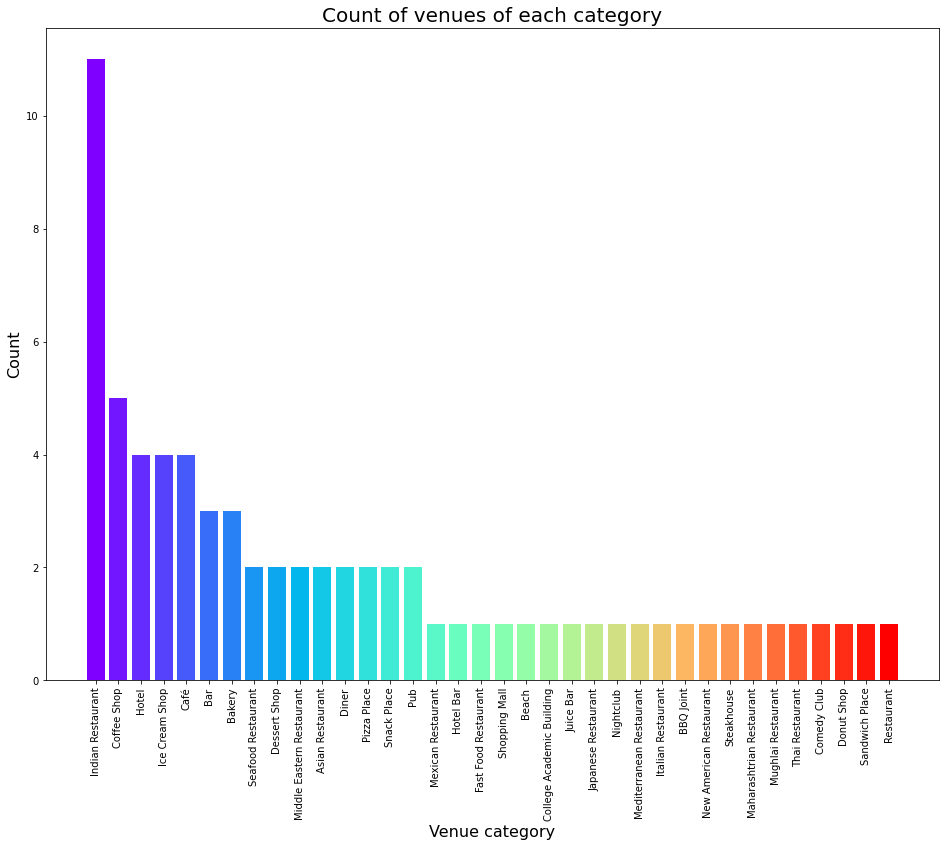

In [19]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 20)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Indian restaurant, and at second comes BAR,Cafe,coffee shop and Ice cream shops. So, if as a tourist, you're looking for these places, you're in luck.

# Rating
Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To get to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and colour code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating

Text(0.5, 1.0, 'Count of venues with given rating')

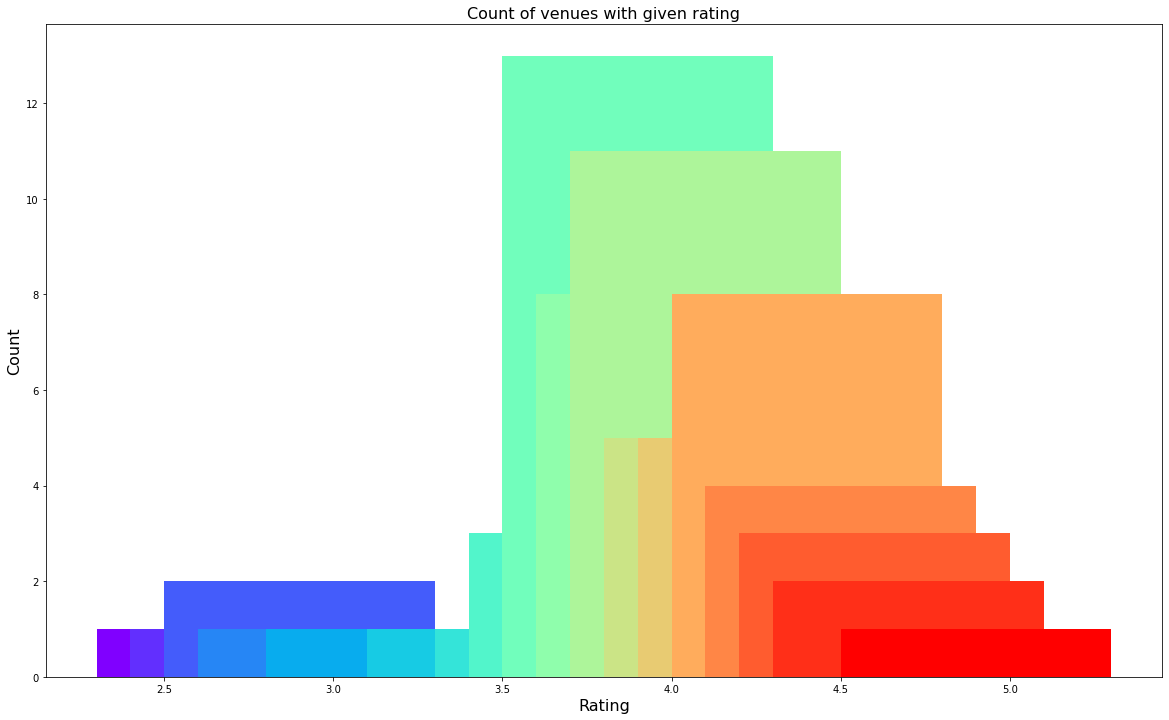

In [20]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the above chart we can see that the majority of places has rating from 3.5 to 4.3

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

1 to 2

2 to 3

3 to 4

4 to 5

In [23]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

plotting the venues in the graph

In [24]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mumbai_map)  
mumbai_map

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [25]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(mumbai_map)  
mumbai_map

As you can see the places near Mumbai Naval Base with Red markers are expensive and places to the east of Mumbai Naval base is less cheaper in price range.

# Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [ ]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues

In [28]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mumbai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mumbai_map)

mumbai_map

Here are clusters near Mumbai Naval base in Red colour which has very high price range.

Other Clusters in Green Colour.



## Clusters 1
Checking the venues for the red clusters

In [29]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Mexican Restaurant,Cream Centre,18.9555,72.8132,3.0,4.1,"Fulchand Niwas, Chowpatty Sea Face, Chowpatty,...",775.0,Very good
1,0,Nightclub,Neel - Tote On The Turf,18.9805,72.8205,3.0,4.0,"Gate 5 & 6, Mahalaxmi Racecourse, Keshva Rao, ...",850.0,Good
2,0,Hotel,Dome - InterContinental,18.9349,72.8241,4.0,4.4,"Hotel InterContinental, 135, Churchgate, Mumbai",1750.0,Very good
3,0,Seafood Restaurant,Trishna,18.9287,72.8323,4.0,4.6,"7, Sai Baba Marg, Kala Ghoda, Fort, Mumbai",1050.0,Very good
4,0,Pizza Place,Pizza By The Bay,18.9334,72.8239,4.0,4.4,"143, Soona Mahal, Marine Drive, Churchgate, Mu...",1000.0,Very good
5,0,Restaurant,Smoke House Deli,18.9944,72.8243,4.0,4.4,"462, High Street Phoenix, Senapati Bapat Marg,...",1250.0,Very good
6,0,Hotel,Harbour Bar - The Taj Mahal Palace,18.9221,72.8337,4.0,4.0,"The Taj Mahal Palace & Tower, Apollo Bunder, C...",1250.0,Good
7,0,Asian Restaurant,Burma Burma,18.9296,72.8320,3.0,4.7,"Near Mumbai University, Kothari House, Allana ...",800.0,Very good
8,0,Comedy Club,Smoke House Deli,18.9944,72.8243,4.0,4.4,"462, High Street Phoenix, Senapati Bapat Marg,...",1250.0,Very good
9,0,Pub,Woodside Inn,18.9246,72.8320,4.0,4.6,"Opposite Regal Cinema, Wodehouse Road, Colaba,...",1100.0,Very good


In [30]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 3.67 and rating spread around 4.28


## Clusters 2

the below estimation is based on the greenmarkers

In [31]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",500.0,Good
1,1,Indian Restaurant,Swati Snacks,18.9666,72.8136,1.0,4.4,"248, Karai Estate, Opposite Bhatia Hospital, T...",225.0,Very good
2,1,Ice Cream Shop,Bachelorr's,18.9542,72.8153,2.0,3.8,"45, Chowpatty Sea Face, Netaji Subhash Chandra...",250.0,Good
3,1,Coffee Shop,TNBT : The Next Big Thing,18.9564,72.8121,2.0,3.9,"29/A, Jethabhai Govindji Building, Opposite Me...",425.0,Good
4,1,Indian Restaurant,Shree Thaker Bhojanalay,18.9512,72.8283,3.0,4.9,"31, Dadisheth Agyari Lane, Off Kalbadevi Road,...",650.0,Very good
5,1,Indian Restaurant,Jaffer Bhai's Delhi Darbar,18.9615,72.8233,3.0,4.0,"195/197, Patthe Bapu Rao Marg, Grant Road East...",500.0,Good
6,1,Indian Restaurant,Soam,18.9574,72.8089,2.0,4.5,"Plot-15, 2, Ground Floor, Sadguru Sadan, Babul...",400.0,Very good
7,1,Snack Place,Sukh Sagar Juice,18.9561,72.8134,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat...",175.0,Good
8,1,Bakery,Theobroma,18.9708,72.8099,2.0,4.2,"A/2, A Wing, Poornima Building, Near Jaslok Ho...",250.0,Very good
9,1,Juice Bar,Sukh Sagar Juice,18.9561,72.8134,1.0,3.9,"542 A, Gandhi Building, SVP Road, Near Chowpat...",175.0,Good


In [32]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.79 and rating spread around 3.98


# Result and Discussion
Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Mumbai, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 168 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 76.

We identified that from the total set of venues, majority of them were Hotel and Pizza Places.

Finally, through clusters we identified that there are many venues which are relatively high priced but have an average rating of 4.28. On the other hand, there are few venues which are less priced and have average rating of 3.98.

A consumer and food explorer can use this information to explore or research and a company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

# Conclusion
The purpose of this project was to explore the places that a person visiting to South Mumbai . The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are so many places where one can visit during his stay in South Mumbai. Based on the visitor's venue rating and price requirements,they can choose the places.